# ML - Problem Set 2: Predicting Poverty

El objetivo principal es construir un modelo predictivo de la pobreza de los hogares. Nótese que un hogar se clasifica como

\begin{equation}
    Poor = I \left( Inc < Pl \right)
\end{equation}

donde $I$ es una función indicadora que toma uno si el ingreso familiar está por debajo de una determinada línea de pobreza.

## Paso 1. Procesamiento de datos

In [1]:
# Importar librerías necesarias

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table

# Modelado
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Preprocesamiento y evaluación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

# Modelos estadísticos
import statsmodels.api as sm

In [2]:
# Importar datos

test_hogares = pd.read_csv('test_hogares.csv')
train_hogares = pd.read_csv('train_hogares.csv')
test_personas = pd.read_csv('test_personas.csv')
train_personas = pd.read_csv('train_personas.csv')
tipo_var_personas = pd.read_excel("tipo_var.xlsx", sheet_name="Personas")
tipo_var_hogares = pd.read_excel("tipo_var.xlsx", sheet_name="Hogares")

In [3]:
# Limpieza de datos

train_personas['P6210s1'] = train_personas['P6210s1'].clip(lower=0, upper=15)  # Eliminar valores extremos
test_personas['P6210s1'] = test_personas['P6210s1'].clip(lower=0, upper=15)  # Eliminar valores extremos

train_personas['P7510s5'] = train_personas['P7510s5'].clip(lower=1, upper=2)  # Eliminar valores extremos
test_personas['P7510s5'] = test_personas['P7510s5'].clip(lower=1, upper=2)  # Eliminar valores extremos

train_personas['Des'] = train_personas['Des'].fillna(0)  # Reemplazar NaN por 0
train_personas['Ina'] = train_personas['Ina'].fillna(0)  # Reemplazar NaN por 0
test_personas['Des'] = test_personas['Des'].fillna(0)  # Reemplazar NaN por 0
test_personas['Ina'] = test_personas['Ina'].fillna(0)  # Reemplazar NaN por 0
train_personas['Oc'] = train_personas['Oc'].fillna(0) # Reemplazar NaN por 0
test_personas['Oc'] = test_personas['Oc'].fillna(0) # Reemplazar NaN por 0

# Imprimir valores únicos de train_personas
variables_personas = ['Dominio', 'P6020', 'P6040', 'P6050', 'P6210s1', 'P6920', 'P7510s5', 'Oc']
for var in variables_personas:
    valores_unicos = sorted(train_personas[var].unique())
    print(f"Valores únicos en {var} (train_personas):", valores_unicos)

# Imprimir valores únicos de train_hogares
variables_hogares = ['Dominio', 'P5010', 'P5130', 'Nper']
for var in variables_hogares:
    valores_unicos = sorted(train_hogares[var].unique())
    print(f"Valores únicos en {var} (train_hogares):", valores_unicos)

Valores únicos en Dominio (train_personas): ['ARMENIA', 'BARRANQUILLA', 'BOGOTA', 'BUCARAMANGA', 'CALI', 'CARTAGENA', 'CUCUTA', 'FLORENCIA', 'IBAGUE', 'MANIZALES', 'MEDELLIN', 'MONTERIA', 'NEIVA', 'PASTO', 'PEREIRA', 'POPAYAN', 'QUIBDO', 'RESTO URBANO', 'RIOHACHA', 'RURAL', 'SANTA MARTA', 'SINCELEJO', 'TUNJA', 'VALLEDUPAR', 'VILLAVICENCIO']
Valores únicos en P6020 (train_personas): [1, 2]
Valores únicos en P6040 (train_personas): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110]
Valores únicos en P6050 (train_personas): [1, 2, 3, 4, 5, 6, 7, 8, 9]
Valores únicos en P6210s1 (train_personas): [3.0, nan, 

In [4]:
# Imputar valores nulos

imputador_moda = SimpleImputer(strategy='most_frequent')  # Para variables categóricas (dummies)
imputador_mediana = SimpleImputer(strategy='median')  # Para variables numéricas

# Función para imputar datos faltantes basada en los DataFrames de tipo_var
def imputar_datos_con_tipo(df, tipo_var):
    """
    Imputa valores faltantes diferenciando entre variables dummy (moda) y numéricas (mediana).
    """
    # Filtrar nombres de variables según el tipo
    variables_dummy = tipo_var[tipo_var['Tipo.1'] == 'D']['Nombre']
    variables_numericas = tipo_var[tipo_var['Tipo.1'] == 'N']['Nombre']

    # Imputar dummies con la moda
    for var in variables_dummy:
        if var in df.columns:  # Verifica que la columna esté en el DataFrame
            df[[var]] = imputador_moda.fit_transform(df[[var]])

    # Imputar numéricas con la mediana
    for var in variables_numericas:
        if var in df.columns:  # Verifica que la columna esté en el DataFrame
            df[[var]] = imputador_mediana.fit_transform(df[[var]])

    return df

# Aplicar la imputación a cada DataFrame utilizando tipo_var_personas y tipo_var_hogares
train_hogares = imputar_datos_con_tipo(train_hogares, tipo_var_hogares)
test_hogares = imputar_datos_con_tipo(test_hogares, tipo_var_hogares)
train_personas = imputar_datos_con_tipo(train_personas, tipo_var_personas)
test_personas = imputar_datos_con_tipo(test_personas, tipo_var_personas)

# Verificar valores faltantes después de la imputación
print("Valores faltantes después de imputación:")
print("train_hogares:", train_hogares.isnull().sum().sum())
print("test_hogares:", test_hogares.isnull().sum().sum())
print("train_personas:", train_personas.isnull().sum().sum())
print("test_personas:", test_personas.isnull().sum().sum())

Valores faltantes después de imputación:
train_hogares: 0
test_hogares: 0
train_personas: 0
test_personas: 0


In [5]:
# Verficar variables

print(test_hogares.columns.tolist())
print(train_hogares.columns.tolist())
print(test_personas.columns.tolist())
print(train_personas.columns.tolist())

['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'P5100', 'P5130', 'P5140', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto']
['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'P5100', 'P5130', 'P5140', 'Nper', 'Npersug', 'Ingtotug', 'Ingtotugarr', 'Ingpcug', 'Li', 'Lp', 'Pobre', 'Indigente', 'Npobres', 'Nindigentes', 'Fex_c', 'Depto', 'Fex_dpto']
['id', 'Orden', 'Clase', 'Dominio', 'P6020', 'P6040', 'P6050', 'P6090', 'P6100', 'P6210', 'P6210s1', 'P6240', 'Oficio', 'P6426', 'P6430', 'P6510', 'P6545', 'P6580', 'P6585s1', 'P6585s2', 'P6585s3', 'P6585s4', 'P6590', 'P6600', 'P6610', 'P6620', 'P6630s1', 'P6630s2', 'P6630s3', 'P6630s4', 'P6630s6', 'P6800', 'P6870', 'P6920', 'P7040', 'P7045', 'P7050', 'P7090', 'P7110', 'P7120', 'P7150', 'P7160', 'P7310', 'P7350', 'P7422', 'P7472', 'P7495', 'P7500s2', 'P7500s3', 'P7505', 'P7510s1', 'P7510s2', 'P7510s3', 'P7510s5', 'P7510s6', 'P7510s7', 'Pet', 'Oc', 'Des', 'Ina', 'Fex_c', 'Depto', 'Fex_dpto']
['id', 'Orden', 'Clase', 'Domini

## Fusionar individuos con hogares

Se crean las siguientes variables:
- promedio_educacion: se espera que a mayor nivel educativo del hogar, mayor sera el ingreso

- hacinamiento: se supone que a mayor hacinamiento, mas probabilidad tiene el hogar de ser pobre

- capacitacion_financiera: se supone que los hogares pobres no tienen capaticacion financiera

- jefe_sex: es posible que los hogares con jefas de hogares mujeres tengan menos ingresos que aquellso donde el jefe de hogar es hombre

- promedio_edad

- sin_jubilacion

- porcentaje_ocupados

In [6]:
# Crear una nueva variable que sea promedio educativo por hogar

# Agrupar por 'id' y sumar los valores de 'P6210s1' para cada hogar en el dataset de entrenamiento
promedio_educacion_train = train_personas.groupby('id')['P6210s1'].sum().reset_index()
promedio_educacion_train.rename(columns={'P6210s1': 'Suma_P6210s1'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
train_hogares = train_hogares.merge(promedio_educacion_train, on='id', how='left')

# Calcular el promedio de educación por hogar
train_hogares['promedio_educacion'] = train_hogares['Suma_P6210s1'] / train_hogares['Nper']

# Repetir el proceso para el conjunto de prueba

# Agrupar por 'id' y sumar los valores de 'P6210s1' para cada hogar en el dataset de prueba
promedio_educacion_test = test_personas.groupby('id')['P6210s1'].sum().reset_index()
promedio_educacion_test.rename(columns={'P6210s1': 'Suma_P6210s1'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
test_hogares = test_hogares.merge(promedio_educacion_test, on='id', how='left')

# Calcular el promedio de educación por hogar
test_hogares['promedio_educacion'] = test_hogares['Suma_P6210s1'] / test_hogares['Nper']

In [7]:
# Crear una nueva variable que sea promedio de personas por habitacion

train_hogares['hacinamiento'] = train_hogares['Nper'] / train_hogares['P5010']

# Calcular el ratio de personas por dormitorio (Aglomeracion) en test_hogares
test_hogares['hacinamiento'] = test_hogares['Nper'] / test_hogares['P5010']

In [8]:
# Crear la variable `capacitacion_financiera` en el set de entrenamiento

capacitacion_train = train_personas.groupby('id')['P7510s5'].apply(lambda x: 1 if (x == 1).any() else 0).reset_index()
capacitacion_train.rename(columns={'P7510s5': 'capacitacion_financiera'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
train_hogares = train_hogares.merge(capacitacion_train, on='id', how='left')

# Crear la variable `capacitacion_financiera` en el set de prueba
capacitacion_test = test_personas.groupby('id')['P7510s5'].apply(lambda x: 1 if (x == 1).any() else 0).reset_index()
capacitacion_test.rename(columns={'P7510s5': 'capacitacion_financiera'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
test_hogares = test_hogares.merge(capacitacion_test, on='id', how='left')

In [9]:
# Crear la variable `jefe_sex`

# Filtrar las personas que son jefes de hogar
jefes_train = train_personas[train_personas['P6050'] == 1][['id', 'P6020']]

# Renombrar la columna `P6020` a `jefe_sex`
jefes_train.rename(columns={'P6020': 'jefe_sex'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
train_hogares = train_hogares.merge(jefes_train, on='id', how='left')

# Crear la variable `jefe_sex` para el conjunto de prueba
jefes_test = test_personas[test_personas['P6050'] == 1][['id', 'P6020']]
jefes_test.rename(columns={'P6020': 'jefe_sex'}, inplace=True)
test_hogares = test_hogares.merge(jefes_test, on='id', how='left')

In [10]:
# Crear una nueva variable que sea promedio de edad por hogar

# Agrupar por 'id' y sumar los valores de 'P6040' (edad) para cada hogar en el dataset de entrenamiento
promedio_edad_train = train_personas.groupby('id')['P6040'].sum().reset_index()
promedio_edad_train.rename(columns={'P6040': 'Suma_Edad'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
train_hogares = train_hogares.merge(promedio_edad_train, on='id', how='left')

# Calcular el promedio de edad por hogar
train_hogares['promedio_edad'] = train_hogares['Suma_Edad'] / train_hogares['Nper']

# Repetir el proceso para el conjunto de prueba

# Agrupar por 'id' y sumar los valores de 'P6040' (edad) para cada hogar en el dataset de prueba
promedio_edad_test = test_personas.groupby('id')['P6040'].sum().reset_index()
promedio_edad_test.rename(columns={'P6040': 'Suma_Edad'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
test_hogares = test_hogares.merge(promedio_edad_test, on='id', how='left')

# Calcular el promedio de edad por hogar
test_hogares['promedio_edad'] = test_hogares['Suma_Edad'] / test_hogares['Nper']

In [11]:
# Crear una nueva variable que sea el porcentaje de individuos sin jubilación por hogar

# Calcular el número de individuos sin jubilación (P6920 == 2) por hogar en el dataset de entrenamiento
sin_jubilacion_train = train_personas[train_personas['P6920'] == 2].groupby('id')['P6920'].count().reset_index()
sin_jubilacion_train.rename(columns={'P6920': 'Num_Sin_Jubilacion'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
train_hogares = train_hogares.merge(sin_jubilacion_train, on='id', how='left')

# Calcular el porcentaje de individuos sin jubilación por hogar
train_hogares['sin_jubilacion'] = train_hogares['Num_Sin_Jubilacion'] / train_hogares['Nper']

# Repetir el proceso para el conjunto de prueba

# Calcular el número de individuos sin jubilación (P6920 == 2) por hogar en el dataset de prueba
sin_jubilacion_test = test_personas[test_personas['P6920'] == 2].groupby('id')['P6920'].count().reset_index()
sin_jubilacion_test.rename(columns={'P6920': 'Num_Sin_Jubilacion'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
test_hogares = test_hogares.merge(sin_jubilacion_test, on='id', how='left')

# Calcular el porcentaje de individuos sin jubilación por hogar
test_hogares['sin_jubilacion'] = test_hogares['Num_Sin_Jubilacion'] / test_hogares['Nper']

# Manejar posibles valores faltantes (hogares sin individuos con P6920 == 2)
train_hogares['sin_jubilacion'] = train_hogares['sin_jubilacion'].fillna(0)
test_hogares['sin_jubilacion'] = test_hogares['sin_jubilacion'].fillna(0)

In [12]:
# Crear la variable `porcentaje_ocupados`

# Crear la variable `porcentaje_ocupados` en el conjunto de entrenamiento
ocupados_train = train_personas.groupby('id')['Oc'].sum().reset_index()  # Sumar las personas ocupadas por hogar
ocupados_train.rename(columns={'Oc': 'Total_Ocupados'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
train_hogares = train_hogares.merge(ocupados_train, on='id', how='left')

# Calcular el porcentaje de personas ocupadas por hogar
train_hogares['porcentaje_ocupados'] = train_hogares['Total_Ocupados'] / train_hogares['Nper']

# Crear la variable `porcentaje_ocupados` en el conjunto de prueba
ocupados_test = test_personas.groupby('id')['Oc'].sum().reset_index()  # Sumar las personas ocupadas por hogar
ocupados_test.rename(columns={'Oc': 'Total_Ocupados'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
test_hogares = test_hogares.merge(ocupados_test, on='id', how='left')

# Calcular el porcentaje de personas ocupadas por hogar
test_hogares['porcentaje_ocupados'] = test_hogares['Total_Ocupados'] / test_hogares['Nper']

# Manejar posibles valores faltantes (hogares sin individuos registrados en 'Oc' o 'Nper')
train_hogares['porcentaje_ocupados'] = train_hogares['porcentaje_ocupados'].fillna(0)
test_hogares['porcentaje_ocupados'] = test_hogares['porcentaje_ocupados'].fillna(0)

In [13]:
# Imprimir valores únicos redondeados a un decimal en train_hogares

variables_hogares = [
    'promedio_educacion',
    'hacinamiento',
    'capacitacion_financiera',
    'jefe_sex',
    'promedio_edad',
    'sin_jubilacion',
    'porcentaje_ocupados'
]

print("Valores únicos (redondeados a un decimal) en el conjunto train_hogares para las variables seleccionadas:\n")
for var in variables_hogares:
    if var in train_hogares.columns:
        valores_unicos = sorted(set(round(x, 1) for x in train_hogares[var].dropna().unique()))
        if len(valores_unicos) > 10:
            print(f"{var}: {valores_unicos[:5]} ... {valores_unicos[-5:]}")
        else:
            print(f"{var}: {valores_unicos}")
    else:
        print(f"{var}: La variable no está presente en train_hogares.")

Valores únicos (redondeados a un decimal) en el conjunto train_hogares para las variables seleccionadas:

promedio_educacion: [0.0, 0.2, 0.3, 0.4, 0.5] ... [12.3, 12.5, 13.0, 14.0, 15.0]
hacinamiento: [0.2, 0.3, 0.4, 0.5, 0.6] ... [11.0, 12.0, 13.0, 15.0, 16.0]
capacitacion_financiera: [0, 1]
jefe_sex: [1, 2]
promedio_edad: [5.7, 5.8, 6.3, 6.8, 7.0] ... [97.0, 98.0, 99.0, 101.0, 102.0]
sin_jubilacion: [0.0, 0.1, 0.2, 0.3, 0.4] ... [0.6, 0.7, 0.8, 0.9, 1.0]
porcentaje_ocupados: [0.0, 0.1, 0.2, 0.3, 0.4] ... [0.6, 0.7, 0.8, 0.9, 1.0]


In [14]:
# Revisar base entrenamiento

train_hogares

,id,Clase,Dominio,P5000,P5010,P5090,P5100,P5130,P5140,Nper,...,promedio_educacion,hacinamiento,capacitacion_financiera,jefe_sex,Suma_Edad,promedio_edad,Num_Sin_Jubilacion,sin_jubilacion,Total_Ocupados,porcentaje_ocupados
0,8d0193e328305a042001a35f,1,MEDELLIN,4.0,2.0,1,500000.0,400000.0,380000.0,5.0,...,5.800000,2.500000,0,1,96.0,19.200000,3.0,0.6,2.0,0.400000
1,cf7491d7f2cc9c216bd009e7,1,MEDELLIN,5.0,4.0,3,500000.0,350000.0,250000.0,4.0,...,2.250000,1.000000,0,1,211.0,52.750000,4.0,1.0,0.0,0.000000
2,d90a57f64d2a84dbacbed2a5,1,MEDELLIN,4.0,2.0,1,500000.0,700000.0,380000.0,3.0,...,4.666667,1.500000,0,2,159.0,53.000000,3.0,1.0,1.0,0.333333
3,db34e387a94a783188ab3a33,1,MEDELLIN,3.0,1.0,1,500000.0,450000.0,380000.0,1.0,...,4.000000,1.000000,0,1,43.0,43.000000,1.0,1.0,1.0,1.000000
4,97bbef785824746ecab09c6f,1,MEDELLIN,4.0,3.0,3,500000.0,350000.0,500000.0,5.0,...,3.000000,1.666667,0,1,171.0,34.200000,5.0,1.0,3.0,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164955,0d168c0d27707687fcbf9b60,1,CALI,3.0,2.0,3,500000.0,350000.0,460000.0,3.0,...,5.333333,1.500000,0,2,181.0,60.333333,3.0,1.0,1.0,0.333333
164956,757f32d9b76aaa11eb93b4a6,1,BOGOTA,3.0,3.0,3,500000.0,350000.0,650000.0,8.0,...,6.250000,2.666667,0,1,187.0,23.375000,8.0,1.0,4.0,0.500000
164957,ff4ecf438cf2375b8d511645,1,BOGOTA,5.0,4.0,1,500000.0,2000000.0,380000.0,10.0,...,7.100000,2.500000,0,1,457.0,45.700000,6.0,0.6,8.0,0.800000
164958,5f037d9ddb23a0223d937b30,1,BOGOTA,2.0,1.0,3,500000.0,350000.0,400000.0,4.0,...,7.750000,4.000000,0,1,57.0,14.250000,2.0,0.5,2.0,0.500000


In [15]:
# Revisar base testeo

test_hogares

,id,Clase,Dominio,P5000,P5010,P5090,P5100,P5130,P5140,Nper,...,promedio_educacion,hacinamiento,capacitacion_financiera,jefe_sex,Suma_Edad,promedio_edad,Num_Sin_Jubilacion,sin_jubilacion,Total_Ocupados,porcentaje_ocupados
0,2a7ddc2779480d7f19834953,1,SANTA MARTA,4.0,3.0,1,500000.0,400000.0,370000.0,5.0,...,4.800000,1.666667,0,1,251.0,50.200000,5.0,1.000000,2.0,0.400000
1,a0c2e751e582fd49d564f308,1,SANTA MARTA,4.0,3.0,4,500000.0,500000.0,370000.0,6.0,...,8.666667,2.000000,0,1,198.0,33.000000,5.0,0.833333,1.0,0.166667
2,57273d19e8464a5ff66a582b,2,RURAL,3.0,1.0,1,500000.0,250000.0,370000.0,2.0,...,3.500000,2.000000,0,1,96.0,48.000000,1.0,0.500000,2.0,1.000000
3,418d052ff7878940ab938601,1,MEDELLIN,4.0,3.0,1,500000.0,600000.0,370000.0,5.0,...,8.000000,1.666667,0,2,206.0,41.200000,4.0,0.800000,2.0,0.400000
4,212a37fc17016a3c78f76852,1,MEDELLIN,5.0,2.0,2,1800000.0,2000000.0,370000.0,2.0,...,7.500000,1.000000,0,1,69.0,34.500000,NaN,0.000000,2.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66163,e7d3c7cc62acd33867b7b7ee,1,BARRANQUILLA,3.0,2.0,3,500000.0,350000.0,450000.0,4.0,...,9.250000,2.000000,0,1,103.0,25.750000,4.0,1.000000,1.0,0.250000
66164,710db9f02de9c616f846c72e,1,CARTAGENA,3.0,2.0,3,500000.0,350000.0,100000.0,5.0,...,6.200000,2.500000,0,2,87.0,17.400000,5.0,1.000000,1.0,0.200000
66165,5a0d6b6fad06e4736fb6d95f,1,ARMENIA,3.0,2.0,3,500000.0,350000.0,250000.0,6.0,...,4.333333,3.000000,0,2,172.0,28.666667,6.0,1.000000,4.0,0.666667
66166,569496964b70185785b57789,1,PEREIRA,2.0,2.0,4,500000.0,300000.0,370000.0,5.0,...,5.400000,2.500000,0,1,115.0,23.000000,5.0,1.000000,1.0,0.200000


## Estadistica descriptiva

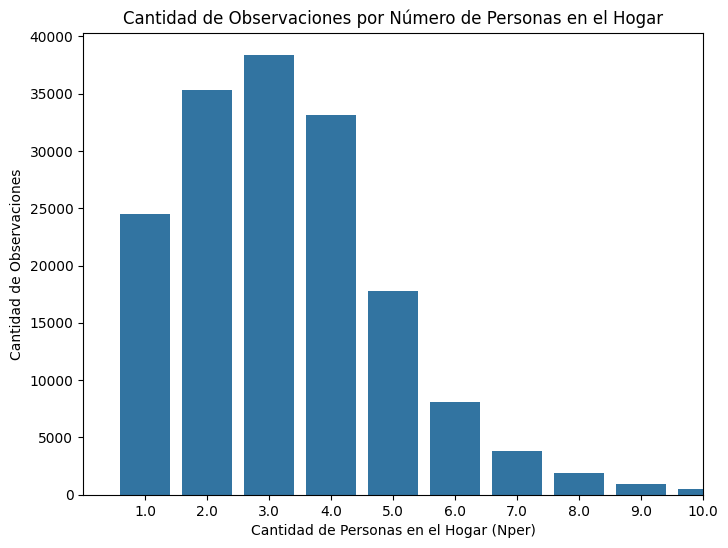

In [16]:
# Gráfico de barras para la cantidad de personas (Nper)

plt.figure(figsize=(8, 6))
sns.countplot(data=train_hogares, x='Nper')
plt.xlabel('Cantidad de Personas en el Hogar (Nper)')
plt.ylabel('Cantidad de Observaciones')
plt.title('Cantidad de Observaciones por Número de Personas en el Hogar')

# Limitar el eje x hasta 8 personas
plt.xlim(-1, 9)

plt.show()

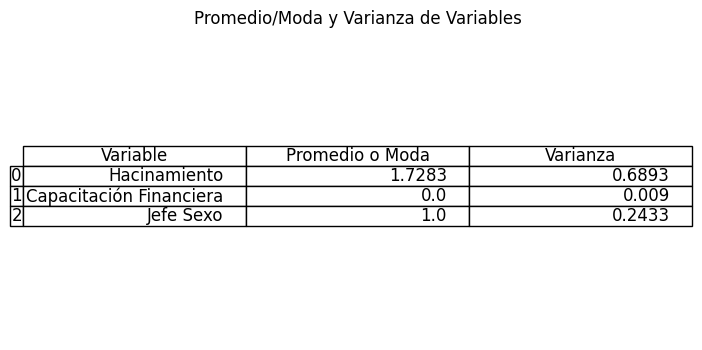

In [17]:



# Promedio y varianza de las variables
promedio_hacinamiento = round(train_hogares['hacinamiento'].mean(), 4)

# Calcular la moda para 'capacitacion_financiera' y 'jefe_sex'
moda_capacitacion = train_hogares['capacitacion_financiera'].mode()[0]  # La moda es el valor más frecuente
moda_jefe_sex = train_hogares['jefe_sex'].mode()[0]  # La moda es el valor más frecuente

# Calcular la varianza para 'hacinamiento', 'capacitacion_financiera', 'jefe_sex'
varianza_hacinamiento = round(train_hogares['hacinamiento'].var(), 4)
varianza_capacitacion = round(train_hogares['capacitacion_financiera'].var(), 4)
varianza_jefe_sex = round(train_hogares['jefe_sex'].var(), 4)

# Crear un DataFrame con los resultados
resumen_estadisticas = pd.DataFrame({
    'Variable': ['Hacinamiento', 'Capacitación Financiera', 'Jefe Sexo'],
    'Promedio o Moda': [promedio_hacinamiento, moda_capacitacion, moda_jefe_sex],
    'Varianza': [varianza_hacinamiento, varianza_capacitacion, varianza_jefe_sex]
})

# Graficar la tabla
fig, ax = plt.subplots(figsize=(8, 4))  # Tamaño del gráfico
ax.axis('off')  # Apagar los ejes

# Añadir la tabla al gráfico sin índice
tabla = table(ax, resumen_estadisticas, loc='center', colWidths=[0.3, 0.3, 0.3])

# Personalizar la apariencia de la tabla (opcional)
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
tabla.scale(1.2, 1.2)

# Mostrar el gráfico con la tabla
plt.title('Promedio/Moda y Varianza de Variables')
plt.show()

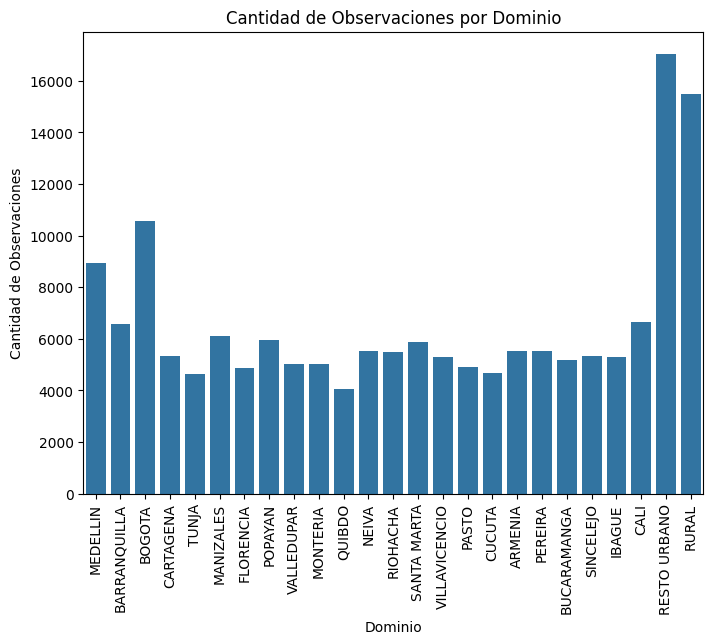

In [18]:
# Gráfico de barras por dominio
plt.figure(figsize=(8, 6))
sns.countplot(data=train_hogares, x='Dominio')
plt.xlabel('Dominio')
plt.ylabel('Cantidad de Observaciones')
plt.title('Cantidad de Observaciones por Dominio')
plt.xticks(rotation=90)
plt.show()

## Modelos

### 1. Regresion lineal

In [19]:
# Modelo OLS

# Definir las variables independientes y dependiente
X = train_hogares[['Dominio', 'P5130', 'promedio_educacion', 'hacinamiento',
                   'capacitacion_financiera', 'jefe_sex', 'promedio_edad',
                   'sin_jubilacion', 'porcentaje_ocupados']]
y = train_hogares['Ingpcug']

# Crear dummies para variables categóricas
X = pd.get_dummies(X, columns=['Dominio'], drop_first=True)

# Escalar variables para métodos que lo requieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir X e y a formato flotante para evitar errores en WLS
X_const = sm.add_constant(X.astype(float))
y = y.astype(float)

# Resultados
resultados = {}

# 1. Regresión Lineal (MCO)
modelo_ols = LinearRegression()
modelo_ols.fit(X, y)
y_pred_ols = modelo_ols.predict(X)
resultados['OLS'] = {
    'MSE': mean_squared_error(y, y_pred_ols),
    'R2': r2_score(y, y_pred_ols)
}

# 2. Ridge
modelo_ridge = Ridge(alpha=1.0)
modelo_ridge.fit(X_scaled, y)
y_pred_ridge = modelo_ridge.predict(X_scaled)
resultados['Ridge'] = {
    'MSE': mean_squared_error(y, y_pred_ridge),
    'R2': r2_score(y, y_pred_ridge)
}

# 3. Lasso
modelo_lasso = Lasso(alpha=0.01)
modelo_lasso.fit(X_scaled, y)
y_pred_lasso = modelo_lasso.predict(X_scaled)
resultados['Lasso'] = {
    'MSE': mean_squared_error(y, y_pred_lasso),
    'R2': r2_score(y, y_pred_lasso)
}

# 4. Elastic Net
modelo_elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
modelo_elastic.fit(X_scaled, y)
y_pred_elastic = modelo_elastic.predict(X_scaled)
resultados['Elastic Net'] = {
    'MSE': mean_squared_error(y, y_pred_elastic),
    'R2': r2_score(y, y_pred_elastic)
}

# 5. Weighted Least Squares (WLS)
pesos = 1 / (X['hacinamiento'].clip(lower=0) + 1)  #
modelo_wls = sm.WLS(y, X_const, weights=pesos).fit()
y_pred_wls = modelo_wls.predict(X_const)
resultados['WLS'] = {
    'MSE': mean_squared_error(y, y_pred_wls),
    'R2': r2_score(y, y_pred_wls)
}

# Imprimir Resultados
print("Resultados de los Modelos:")
for modelo, metricas in resultados.items():
    print(f"{modelo}: MSE = {metricas['MSE']:.2f}, R2 = {metricas['R2']:.4f}")

Resultados de los Modelos:
OLS: MSE = 1171999815367.90, R2 = 0.2431
Ridge: MSE = 1171999815387.89, R2 = 0.2431
Lasso: MSE = 1171999815367.93, R2 = 0.2431
Elastic Net: MSE = 1172012102957.72, R2 = 0.2431
WLS: MSE = 1173607548755.92, R2 = 0.2420


In [20]:
# Usar el modelo OLS estimado en train_hogares para predecir en test_hogares

# Seleccionar las mismas variables independientes en test_hogares
X_test = test_hogares[['Dominio', 'P5130', 'promedio_educacion', 'hacinamiento',
                       'capacitacion_financiera', 'jefe_sex', 'promedio_edad',
                       'sin_jubilacion', 'porcentaje_ocupados']]

# Manejar valores faltantes en test_hogares
X_test = X_test.fillna(0)

# Crear dummies para las variables categóricas en test_hogares (asegurar consistencia con el modelo)
X_test = pd.get_dummies(X_test, columns=['Dominio'], drop_first=True)

# Asegurarse de que las columnas de test coincidan con las de train
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Predecir el valor de "Npersug" usando el modelo OLS
test_hogares['Npersug_pred'] = modelo_ols.predict(X_test)

# Crear la columna "Pobre" comparando "Npersug_pred" con "Lp"
test_hogares['Pobre'] = (test_hogares['Npersug_pred'] < test_hogares['Lp']).astype(int)

# Verificar los resultados
print(test_hogares[['Npersug_pred', 'Lp', 'Pobre']].head())

# Resumen de la columna "Pobre"
print("Distribución de la pobreza (0 = No Pobre, 1 = Pobre):")
print(test_hogares['Pobre'].value_counts())

# Crear el DataFrame regression_ols con las columnas id y Pobre
regression_ols = test_hogares[['id', 'Pobre']].copy()

# Exportar regression_ols a un archivo CSV con el formato especificado
regression_ols.to_csv('regression_ols.csv', index=False, header=['id', 'pobre'], sep=',')

   Npersug_pred             Lp  Pobre
0  7.177631e+05  275594.029448      0
1  7.590158e+05  275594.029448      0
2  1.242148e+06  170886.447382      0
3  1.058588e+06  294093.665341      0
4  2.384024e+06  293293.411227      0
Distribución de la pobreza (0 = No Pobre, 1 = Pobre):
Pobre
0    55908
1    10260
Name: count, dtype: int64


### 2. Logit

Resultados del Modelo Logit Básico:
Precisión en Entrenamiento: 0.8451
Precisión en Prueba: 0.8451
ROC-AUC: 0.8753

Matriz de Confusión:
[[37541  2040]
 [ 5625  4282]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     39581
           1       0.68      0.43      0.53      9907

    accuracy                           0.85     49488
   macro avg       0.77      0.69      0.72     49488
weighted avg       0.83      0.85      0.83     49488



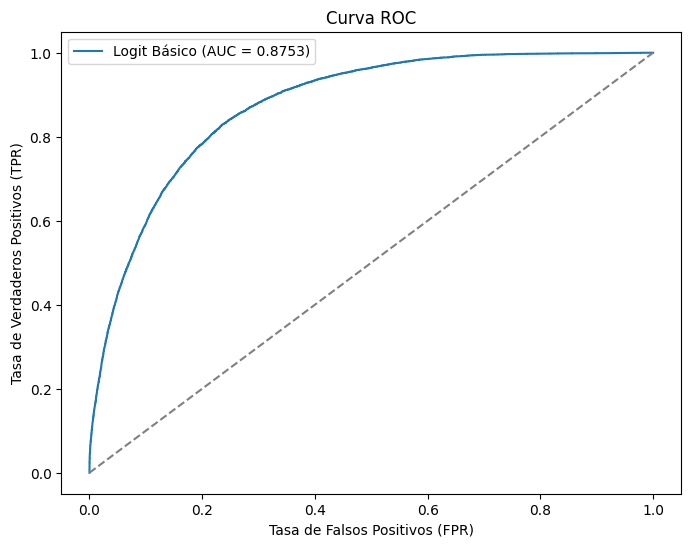


Resultados del Modelo Logit con Pesos Balanceados:
Precisión en Entrenamiento: 0.7642
Precisión en Prueba: 0.7661
ROC-AUC: 0.8712

Matriz de Confusión (Pesos Balanceados):
[[29659  9922]
 [ 1652  8255]]

Reporte de Clasificación (Pesos Balanceados):
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     39581
           1       0.45      0.83      0.59      9907

    accuracy                           0.77     49488
   macro avg       0.70      0.79      0.71     49488
weighted avg       0.85      0.77      0.79     49488



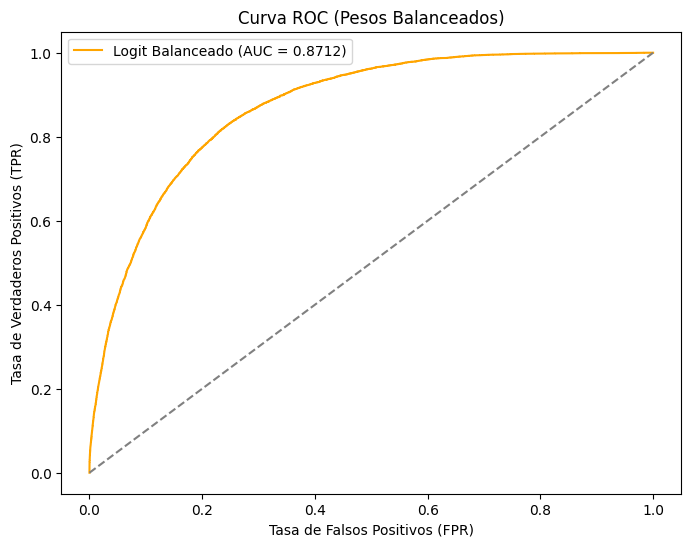

In [21]:
# Crear la variable dependiente 'Pobre'
y = train_hogares['Pobre']  # Variable binaria que indica si el hogar es pobre (1) o no (0)

# Definir las variables independientes
X = train_hogares[['Dominio', 'P5130', 'promedio_educacion', 'hacinamiento',
                   'capacitacion_financiera', 'jefe_sex', 'promedio_edad',
                   'sin_jubilacion', 'porcentaje_ocupados']]

# Crear dummies para variables categóricas
X = pd.get_dummies(X, columns=['Dominio'], drop_first=True)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# Escalar variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo Logit Básico
modelo_logit = LogisticRegression(max_iter=1000, random_state=123)
modelo_logit.fit(X_train_scaled, y_train)

# Predicciones
y_train_pred = modelo_logit.predict(X_train_scaled)
y_test_pred = modelo_logit.predict(X_test_scaled)
y_test_proba = modelo_logit.predict_proba(X_test_scaled)[:, 1]

# Evaluar el modelo
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Imprimir resultados
print("Resultados del Modelo Logit Básico:")
print(f"Precisión en Entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en Prueba: {test_accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Matriz de Confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_test_pred))

# Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_test_pred))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logit Básico (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Modelo Logit con Pesos Balanceados
modelo_logit_balanced = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=123)
modelo_logit_balanced.fit(X_train_scaled, y_train)

# Predicciones
y_train_pred_bal = modelo_logit_balanced.predict(X_train_scaled)
y_test_pred_bal = modelo_logit_balanced.predict(X_test_scaled)
y_test_proba_bal = modelo_logit_balanced.predict_proba(X_test_scaled)[:, 1]

# Evaluar el modelo
train_accuracy_bal = accuracy_score(y_train, y_train_pred_bal)
test_accuracy_bal = accuracy_score(y_test, y_test_pred_bal)
roc_auc_bal = roc_auc_score(y_test, y_test_proba_bal)

# Imprimir resultados
print("\nResultados del Modelo Logit con Pesos Balanceados:")
print(f"Precisión en Entrenamiento: {train_accuracy_bal:.4f}")
print(f"Precisión en Prueba: {test_accuracy_bal:.4f}")
print(f"ROC-AUC: {roc_auc_bal:.4f}")

# Matriz de Confusión
print("\nMatriz de Confusión (Pesos Balanceados):")
print(confusion_matrix(y_test, y_test_pred_bal))

# Reporte de Clasificación
print("\nReporte de Clasificación (Pesos Balanceados):")
print(classification_report(y_test, y_test_pred_bal))

# Curva ROC
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test, y_test_proba_bal)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bal, tpr_bal, label=f'Logit Balanceado (AUC = {roc_auc_bal:.4f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Pesos Balanceados)')
plt.legend()
plt.show()

In [22]:
# Evaluar modelos logit

X_test_hogares = test_hogares[['Dominio', 'P5130', 'promedio_educacion', 'hacinamiento',
                               'capacitacion_financiera', 'jefe_sex', 'promedio_edad',
                               'sin_jubilacion', 'porcentaje_ocupados']]

# Manejar valores faltantes
X_test_hogares = X_test_hogares.fillna(0)

# Crear dummies para las variables categóricas en test_hogares (asegurar consistencia con el modelo)
X_test_hogares = pd.get_dummies(X_test_hogares, columns=['Dominio'], drop_first=True)

# Asegurar que las columnas de test_hogares coincidan con las del modelo (X_train)
X_test_hogares = X_test_hogares.reindex(columns=X_train.columns, fill_value=0)

# Escalar las variables de test_hogares
X_test_hogares_scaled = scaler.transform(X_test_hogares)

# Predecir con el primer modelo (modelo_logit)
test_hogares['Pobre_logit_1'] = modelo_logit.predict(X_test_hogares_scaled)

# Predecir con el segundo modelo (modelo_logit_balanced)
test_hogares['Pobre_logit_2'] = modelo_logit_balanced.predict(X_test_hogares_scaled)

# Verificar resultados
test_hogares

0.6120450226575063


In [23]:
# Exportar modelos logit

# Crear DataFrame para el primer archivo
classification_logit_1 = test_hogares[['id', 'Pobre_logit_1']].copy()

# Crear DataFrame para el segundo archivo
classification_logit_2 = test_hogares[['id', 'Pobre_logit_2']].copy()

# Exportar el primer archivo CSV
classification_logit_1.to_csv('classification_logit_1.csv', index=False, header=['id', 'Pobre_logit_1'])

# Exportar el segundo archivo CSV
classification_logit_2.to_csv('classification_logit_2.csv', index=False, header=['id', 'Pobre_logit_2'])

### 3. Boosting

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Resultados del Modelo AdaBoost (Default):
Precisión en Prueba: 0.8583
ROC-AUC: 0.8974

Matriz de Confusión:
[[37221  2360]
 [ 4652  5255]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     39581
           1       0.69      0.53      0.60      9907

    accuracy                           0.86     49488
   macro avg       0.79      0.74      0.76     49488
weighted avg       0.85      0.86      0.85     49488

Resultados del Modelo AdaBoost (Mayor Profundidad):
Precisión en Prueba: 0.8547
ROC-AUC: 0.8886

Matriz de Confusión:
[[36950  2631]
 [ 4558  5349]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     39581
           1       0.67      0.54      0.60      9907

    accuracy                           0.85     49488
   macro avg       0.78      0.74      0.75     49488
weighted avg       0.85      0.85      0.85     49488

Resu

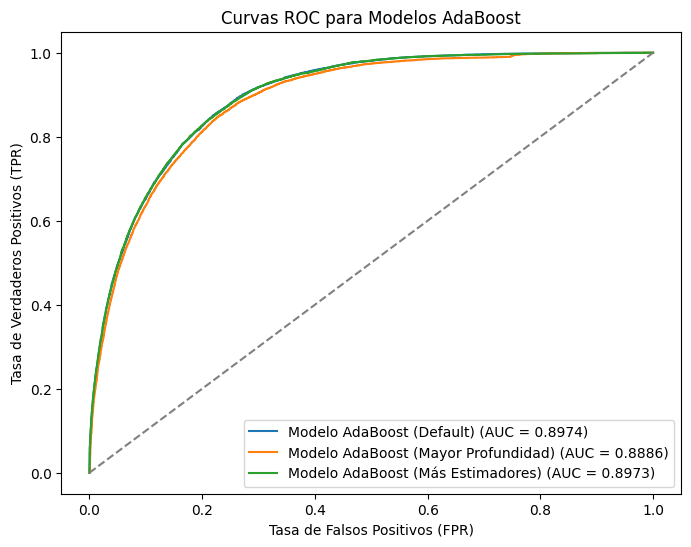

In [24]:
# Modelos Boosting

# Crear la variable dependiente 'Pobre'
y = train_hogares['Pobre']  # Variable binaria que indica si el hogar es pobre (1) o no (0)

# Definir las variables independientes
X = train_hogares[['Dominio', 'P5130', 'promedio_educacion', 'hacinamiento',
                   'capacitacion_financiera', 'jefe_sex', 'promedio_edad',
                   'sin_jubilacion', 'porcentaje_ocupados']]

# Crear dummies para variables categóricas
X = pd.get_dummies(X, columns=['Dominio'], drop_first=True)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los modelos AdaBoost
modelo_ada_default = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=123)
modelo_ada_deep = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=100, random_state=123)
modelo_ada_more_estimators = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=200, random_state=123)

# Entrenar los modelos
modelo_ada_default.fit(X_train_scaled, y_train)
modelo_ada_deep.fit(X_train_scaled, y_train)
modelo_ada_more_estimators.fit(X_train_scaled, y_train)

# Calcular las probabilidades predichas y predicciones para el modelo por defecto
y_test_proba_default = modelo_ada_default.predict_proba(X_test_scaled)[:, 1]
y_test_pred_default = modelo_ada_default.predict(X_test_scaled)

# Calcular las probabilidades predichas y predicciones para el modelo con mayor profundidad
y_test_proba_deep = modelo_ada_deep.predict_proba(X_test_scaled)[:, 1]
y_test_pred_deep = modelo_ada_deep.predict(X_test_scaled)

# Calcular las probabilidades predichas y predicciones para el modelo con más estimadores
y_test_proba_more_estimators = modelo_ada_more_estimators.predict_proba(X_test_scaled)[:, 1]
y_test_pred_more_estimators = modelo_ada_more_estimators.predict(X_test_scaled)

# Evaluar los modelos
def evaluar_modelo(nombre, y_test, y_test_pred, y_test_proba):
    accuracy = accuracy_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    print(f"Resultados del {nombre}:")
    print(f"Precisión en Prueba: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_test_pred))
    return roc_auc

roc_auc_default = evaluar_modelo("Modelo AdaBoost (Default)", y_test, y_test_pred_default, y_test_proba_default)
roc_auc_deep = evaluar_modelo("Modelo AdaBoost (Mayor Profundidad)", y_test, y_test_pred_deep, y_test_proba_deep)
roc_auc_more_estimators = evaluar_modelo("Modelo AdaBoost (Más Estimadores)", y_test, y_test_pred_more_estimators, y_test_proba_more_estimators)

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
for nombre, y_proba in zip(
        ["Modelo AdaBoost (Default)", "Modelo AdaBoost (Mayor Profundidad)", "Modelo AdaBoost (Más Estimadores)"],
        [y_test_proba_default, y_test_proba_deep, y_test_proba_more_estimators]):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para Modelos AdaBoost')
plt.legend()
plt.show()

In [25]:
# Prediccion de modelos Boosting

# Preparar los datos de test_hogares
hogares_testeo = test_hogares[['Dominio', 'P5130', 'promedio_educacion', 'hacinamiento',
                               'capacitacion_financiera', 'jefe_sex', 'promedio_edad',
                               'sin_jubilacion', 'porcentaje_ocupados']]

# Crear dummies para variables categóricas y alinear columnas con los datos de entrenamiento
hogares_testeo = pd.get_dummies(hogares_testeo, columns=['Dominio'], drop_first=True)
hogares_testeo = hogares_testeo.reindex(columns=X.columns, fill_value=0)  # Asegurar consistencia de columnas

# Escalar las variables
hogares_testeo_scaled = scaler.transform(hogares_testeo)

# Calcular probabilidades predichas para cada modelo
test_hogares['Pobre_ada_default'] = modelo_ada_default.predict_proba(hogares_testeo_scaled)[:, 1]
test_hogares['Pobre_ada_deep'] = modelo_ada_deep.predict_proba(hogares_testeo_scaled)[:, 1]
test_hogares['Pobre_ada_more_estimators'] = modelo_ada_more_estimators.predict_proba(hogares_testeo_scaled)[:, 1]

# Crear columnas binarias de predicción para cada modelo
test_hogares['Pobre_ada_default_bin'] = modelo_ada_default.predict(hogares_testeo_scaled)
test_hogares['Pobre_ada_deep_bin'] = modelo_ada_deep.predict(hogares_testeo_scaled)
test_hogares['Pobre_ada_more_estimators_bin'] = modelo_ada_more_estimators.predict(hogares_testeo_scaled)

# Verificar resultados
test_hogares

,id,Clase,Dominio,P5000,P5010,P5090,P5100,P5130,P5140,Nper,...,Npersug_pred,Pobre,Pobre_logit_1,Pobre_logit_2,Pobre_ada_default,Pobre_ada_deep,Pobre_ada_more_estimators,Pobre_ada_default_bin,Pobre_ada_deep_bin,Pobre_ada_more_estimators_bin
0,2a7ddc2779480d7f19834953,1,SANTA MARTA,4.0,3.0,1,500000.0,400000.0,370000.0,5.0,...,7.177631e+05,0,0,1,0.496128,0.494443,0.497920,0,0,0
1,a0c2e751e582fd49d564f308,1,SANTA MARTA,4.0,3.0,4,500000.0,500000.0,370000.0,6.0,...,7.590158e+05,0,0,0,0.497012,0.497216,0.498303,0,0,0
2,57273d19e8464a5ff66a582b,2,RURAL,3.0,1.0,1,500000.0,250000.0,370000.0,2.0,...,1.242148e+06,0,0,0,0.484998,0.486577,0.492330,0,0,0
3,418d052ff7878940ab938601,1,MEDELLIN,4.0,3.0,1,500000.0,600000.0,370000.0,5.0,...,1.058588e+06,0,0,0,0.486700,0.488404,0.493517,0,0,0
4,212a37fc17016a3c78f76852,1,MEDELLIN,5.0,2.0,2,1800000.0,2000000.0,370000.0,2.0,...,2.384024e+06,0,0,0,0.389843,0.462047,0.401115,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66163,e7d3c7cc62acd33867b7b7ee,1,BARRANQUILLA,3.0,2.0,3,500000.0,350000.0,450000.0,4.0,...,4.661225e+05,0,0,1,0.501404,0.501799,0.500788,1,1,1
66164,710db9f02de9c616f846c72e,1,CARTAGENA,3.0,2.0,3,500000.0,350000.0,100000.0,5.0,...,1.525354e+05,1,1,1,0.504099,0.504033,0.501729,1,1,1
66165,5a0d6b6fad06e4736fb6d95f,1,ARMENIA,3.0,2.0,3,500000.0,350000.0,250000.0,6.0,...,1.704333e+05,1,0,1,0.497345,0.498319,0.498623,0,0,0
66166,569496964b70185785b57789,1,PEREIRA,2.0,2.0,4,500000.0,300000.0,370000.0,5.0,...,1.501448e+05,1,0,1,0.500821,0.504051,0.501726,1,1,1


In [26]:
# Exportar modelos Boosting

# Crear DataFrames con las columnas id y las predicciones binarias para cada modelo
classification_boosting_1 = test_hogares[['id', 'Pobre_ada_default_bin']]
classification_boosting_2 = test_hogares[['id', 'Pobre_ada_deep_bin']]
classification_boosting_3 = test_hogares[['id', 'Pobre_ada_more_estimators_bin']]

# Renombrar las columnas para cumplir con los requisitos de formato
classification_boosting_1.rename(columns={'Pobre_ada_default_bin': 'Pobre'}, inplace=True)
classification_boosting_2.rename(columns={'Pobre_ada_deep_bin': 'Pobre'}, inplace=True)
classification_boosting_3.rename(columns={'Pobre_ada_more_estimators_bin': 'Pobre'}, inplace=True)

# Exportar cada DataFrame a un archivo CSV
classification_boosting_1.to_csv('classification_boosting_1.csv', index=False, encoding='utf-8')
classification_boosting_2.to_csv('classification_boosting_2.csv', index=False, encoding='utf-8')
classification_boosting_3.to_csv('classification_boosting_3.csv', index=False, encoding='utf-8')

<ipython-input-26-b8dcf0ff0df3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_boosting_1.rename(columns={'Pobre_ada_default_bin': 'Pobre'}, inplace=True)
<ipython-input-26-b8dcf0ff0df3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_boosting_2.rename(columns={'Pobre_ada_deep_bin': 'Pobre'}, inplace=True)
<ipython-input-26-b8dcf0ff0df3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_

### 4. Random Forest

Resultados del Modelo Random Forest (Default):
Precisión en Prueba: 0.8478
ROC-AUC: 0.8790

Matriz de Confusión:
[[36880  2701]
 [ 4832  5075]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     39581
           1       0.65      0.51      0.57      9907

    accuracy                           0.85     49488
   macro avg       0.77      0.72      0.74     49488
weighted avg       0.84      0.85      0.84     49488

Resultados del Modelo Random Forest (Mayor Profundidad):
Precisión en Prueba: 0.8583
ROC-AUC: 0.8954

Matriz de Confusión:
[[37474  2107]
 [ 4907  5000]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     39581
           1       0.70      0.50      0.59      9907

    accuracy                           0.86     49488
   macro avg       0.79      0.73      0.75     49488
weighted avg       0.85      0.86      0.85     4

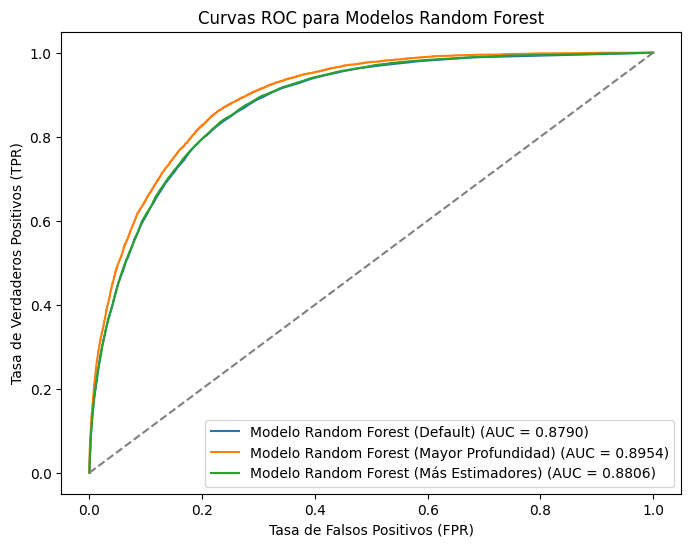

In [27]:
# Estimar por Random Forest

# Crear la variable dependiente 'Pobre'
y = train_hogares['Pobre']  # Variable binaria que indica si el hogar es pobre (1) o no (0)

# Definir las variables independientes
X = train_hogares[['Dominio', 'P5130', 'promedio_educacion', 'hacinamiento',
                   'capacitacion_financiera', 'jefe_sex', 'promedio_edad',
                   'sin_jubilacion', 'porcentaje_ocupados']]

# Crear dummies para variables categóricas
X = pd.get_dummies(X, columns=['Dominio'], drop_first=True)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los modelos Random Forest
modelo_rf_default = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=123)
modelo_rf_deep = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=123)
modelo_rf_more_estimators = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=123)

# Entrenar los modelos
modelo_rf_default.fit(X_train_scaled, y_train)
modelo_rf_deep.fit(X_train_scaled, y_train)
modelo_rf_more_estimators.fit(X_train_scaled, y_train)

# Calcular las probabilidades predichas y predicciones para el modelo por defecto
y_test_proba_default = modelo_rf_default.predict_proba(X_test_scaled)[:, 1]
y_test_pred_default = modelo_rf_default.predict(X_test_scaled)

# Calcular las probabilidades predichas y predicciones para el modelo con mayor profundidad
y_test_proba_deep = modelo_rf_deep.predict_proba(X_test_scaled)[:, 1]
y_test_pred_deep = modelo_rf_deep.predict(X_test_scaled)

# Calcular las probabilidades predichas y predicciones para el modelo con más estimadores
y_test_proba_more_estimators = modelo_rf_more_estimators.predict_proba(X_test_scaled)[:, 1]
y_test_pred_more_estimators = modelo_rf_more_estimators.predict(X_test_scaled)

# Evaluar los modelos
def evaluar_modelo_rf(nombre, y_test, y_test_pred, y_test_proba):
    accuracy = accuracy_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    print(f"Resultados del {nombre}:")
    print(f"Precisión en Prueba: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_test_pred))
    return roc_auc

roc_auc_rf_default = evaluar_modelo_rf("Modelo Random Forest (Default)", y_test, y_test_pred_default, y_test_proba_default)
roc_auc_rf_deep = evaluar_modelo_rf("Modelo Random Forest (Mayor Profundidad)", y_test, y_test_pred_deep, y_test_proba_deep)
roc_auc_rf_more_estimators = evaluar_modelo_rf("Modelo Random Forest (Más Estimadores)", y_test, y_test_pred_more_estimators, y_test_proba_more_estimators)

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
for nombre, y_proba in zip(
        ["Modelo Random Forest (Default)", "Modelo Random Forest (Mayor Profundidad)", "Modelo Random Forest (Más Estimadores)"],
        [y_test_proba_default, y_test_proba_deep, y_test_proba_more_estimators]):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para Modelos Random Forest')
plt.legend()
plt.show()

In [30]:
# Predicción de modelos Random Forest en test_hogares

# Preparar los datos de test_hogares
hogares_testeo = test_hogares[['Dominio', 'P5130', 'promedio_educacion', 'hacinamiento',
                               'capacitacion_financiera', 'jefe_sex', 'promedio_edad',
                               'sin_jubilacion', 'porcentaje_ocupados']]

# Crear dummies para variables categóricas y alinear columnas con los datos de entrenamiento
hogares_testeo = pd.get_dummies(hogares_testeo, columns=['Dominio'], drop_first=True)
hogares_testeo = hogares_testeo.reindex(columns=X.columns, fill_value=0)  # Asegurar consistencia de columnas

# Escalar las variables
hogares_testeo_scaled = scaler.transform(hogares_testeo)

# Calcular probabilidades predichas para cada modelo
test_hogares['Pobre_rf_default'] = modelo_rf_default.predict_proba(hogares_testeo_scaled)[:, 1]
test_hogares['Pobre_rf_deep'] = modelo_rf_deep.predict_proba(hogares_testeo_scaled)[:, 1]
test_hogares['Pobre_rf_more_estimators'] = modelo_rf_more_estimators.predict_proba(hogares_testeo_scaled)[:, 1]

# Crear columnas binarias de predicción para cada modelo
test_hogares['Pobre_rf_default_bin'] = modelo_rf_default.predict(hogares_testeo_scaled)
test_hogares['Pobre_rf_deep_bin'] = modelo_rf_deep.predict(hogares_testeo_scaled)
test_hogares['Pobre_rf_more_estimators_bin'] = modelo_rf_more_estimators.predict(hogares_testeo_scaled)

# Verificar resultados
test_hogares

In [31]:
# Exportar modelos Random Forest

# Crear DataFrames con las columnas id y las predicciones binarias para cada modelo
classification_rf_1 = test_hogares[['id', 'Pobre_rf_default_bin']]
classification_rf_2 = test_hogares[['id', 'Pobre_rf_deep_bin']]
classification_rf_3 = test_hogares[['id', 'Pobre_rf_more_estimators_bin']]

# Renombrar las columnas para cumplir con los requisitos de formato
classification_rf_1.rename(columns={'Pobre_rf_default_bin': 'Pobre'}, inplace=True)
classification_rf_2.rename(columns={'Pobre_rf_deep_bin': 'Pobre'}, inplace=True)
classification_rf_3.rename(columns={'Pobre_rf_more_estimators_bin': 'Pobre'}, inplace=True)

# Exportar cada DataFrame a un archivo CSV
classification_rf_1.to_csv('classification_rf_1.csv', index=False, encoding='utf-8')
classification_rf_2.to_csv('classification_rf_2.csv', index=False, encoding='utf-8')
classification_rf_3.to_csv('classification_rf_3.csv', index=False, encoding='utf-8')
